## ---DEVELOPMENT AND IMPLEMENTATION OF A MACHINE LEARNING MODEL FOR--- 
## ----OPTIMIZATION OF DRAFT FORCE DEMANDS OF DISC PLOUGH FOR TILLAGE--- 
## ---------------------------------------OPERATIONS IN FUNAAB-------------------------------------

### Importing Necessary Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib 
sns.set(style="whitegrid")

from sklearn.preprocessing import LabelEncoder,StandardScaler, RobustScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, StratifiedKFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.cluster import KMeans

# Ignoring warnings for cleaner output
import warnings 
warnings.filterwarnings('ignore')

### Loading and Exploring Data

In [3]:
# Loading the dataset
data = pd.read_csv("FUNAAB_DiscPlough_Dataset.csv")
data.head()

,Soil Moisture Content (%),Bulk Density (g/cm³),Soil Texture,Ploughing Depth (cm),Disc Angle (°),Operating Speed (km/h),Width of Cut (cm),Ambient Temperature (°C),Humidity (%),Draft Force (kN/m)
0,11.988963,2.019891,Sandy Clay Loam,11.847417,39.140889,5.309527,37.874488,18.033918,71.358307,1.95
1,25.817143,2.016633,Sandy Clay Loam,11.215075,30.583552,8.717169,31.280189,35.279719,85.063030,1.95
2,20.567855,2.004092,Sandy Clay Loam,22.083839,39.183905,9.960638,95.406646,27.635699,87.105734,4.25
3,17.367804,2.038581,Sandy Loam,29.322326,31.345029,8.885331,53.307364,30.607210,80.100045,4.25
4,6.744447,2.028130,Sandy Loam,20.054426,40.655164,5.423000,108.166025,34.426749,79.930843,4.25


In [4]:
# Checking the dimension of the dataset
data.shape

(10000, 10)

In [5]:
# Checking the data types and non-null counts of each column
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Soil Moisture Content (%)  10000 non-null  float64
 1   Bulk Density (g/cm³)       10000 non-null  float64
 2   Soil Texture               10000 non-null  object 
 3   Ploughing Depth (cm)       10000 non-null  float64
 4   Disc Angle (°)             10000 non-null  float64
 5   Operating Speed (km/h)     10000 non-null  float64
 6   Width of Cut (cm)          10000 non-null  float64
 7   Ambient Temperature (°C)   10000 non-null  float64
 8   Humidity (%)               10000 non-null  float64
 9   Draft Force (kN/m)         10000 non-null  float64
dtypes: float64(9), object(1)
memory usage: 781.4+ KB


In [6]:
# Providing a statistical summary of numerical columns for insights like min, max, mean, etc.
data.describe()

,Soil Moisture Content (%),Bulk Density (g/cm³),Ploughing Depth (cm),Disc Angle (°),Operating Speed (km/h),Width of Cut (cm),Ambient Temperature (°C),Humidity (%),Draft Force (kN/m)
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,14.859829,2.030362,19.919380,37.464515,6.498002,74.632121,27.047484,78.920249,3.672337
std,6.903123,0.023144,5.729386,4.342118,2.021609,25.684841,5.184123,5.234693,0.793849
min,3.000279,1.990013,10.000111,30.000251,3.000733,30.000751,18.002340,70.001816,1.950000
25%,8.911893,2.010316,14.949029,33.702251,4.740312,52.715596,22.526161,74.301691,3.108264
50%,14.820687,2.030472,19.934290,37.409814,6.521185,74.584392,27.163064,78.941921,4.250000
75%,20.760152,2.050518,24.787699,41.246133,8.249745,97.055211,31.514400,83.473170,4.250000
max,26.993224,2.069994,29.995787,44.999582,9.999699,119.054629,35.997610,87.999857,4.250000


In [7]:
# Checking for missing values to ensure data quality
print("Missing Values ",data.isna().sum().sum())

Missing Values  0


In [8]:
# checking for duplicate values to ensure data quality
print("Duplicated ",data.duplicated().sum().sum())

Duplicated  0


### Exploratory Data Analysis

#### Univariate Analysis 

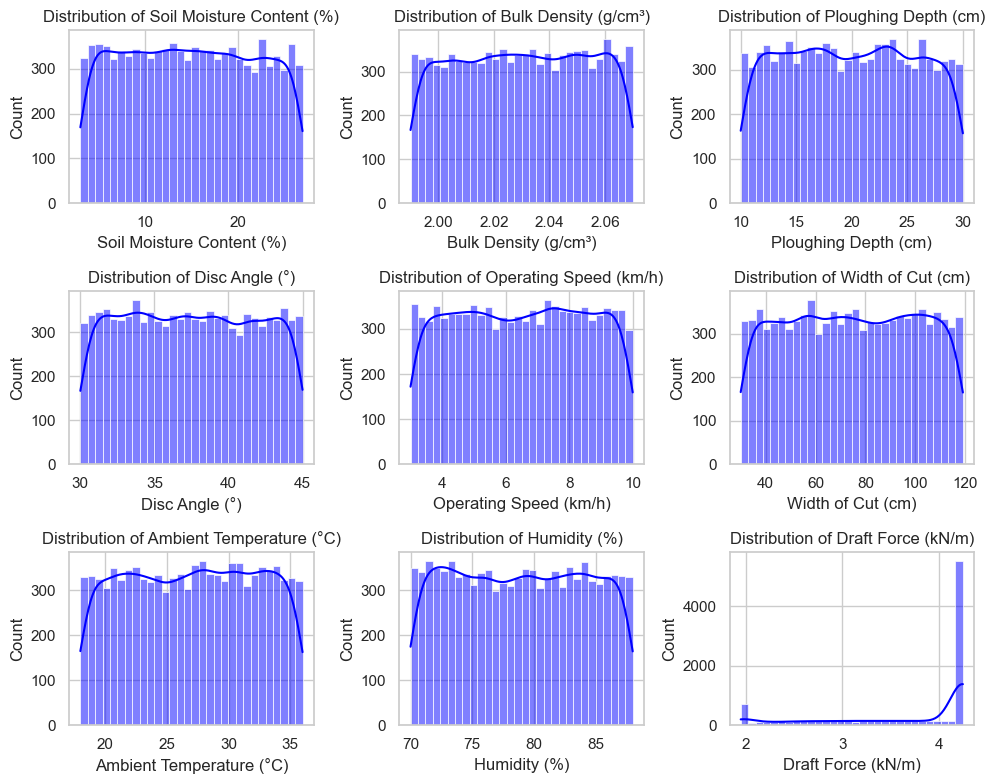

In [9]:
# Histograms for numerical feature
plt.figure(figsize=(10, 8))
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data[col], bins=30, kde=True, color='blue')
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

The Histograms for the numerical features show that:

* Most features follow normal or skewed distributions. 

* Draft Force (kN/m) is bounded between 1.95 and 4.25, as expected. 

* Soil Moisture Content (%) and Bulk Density (g/cm³) show some variation but remain within reasonable ranges.

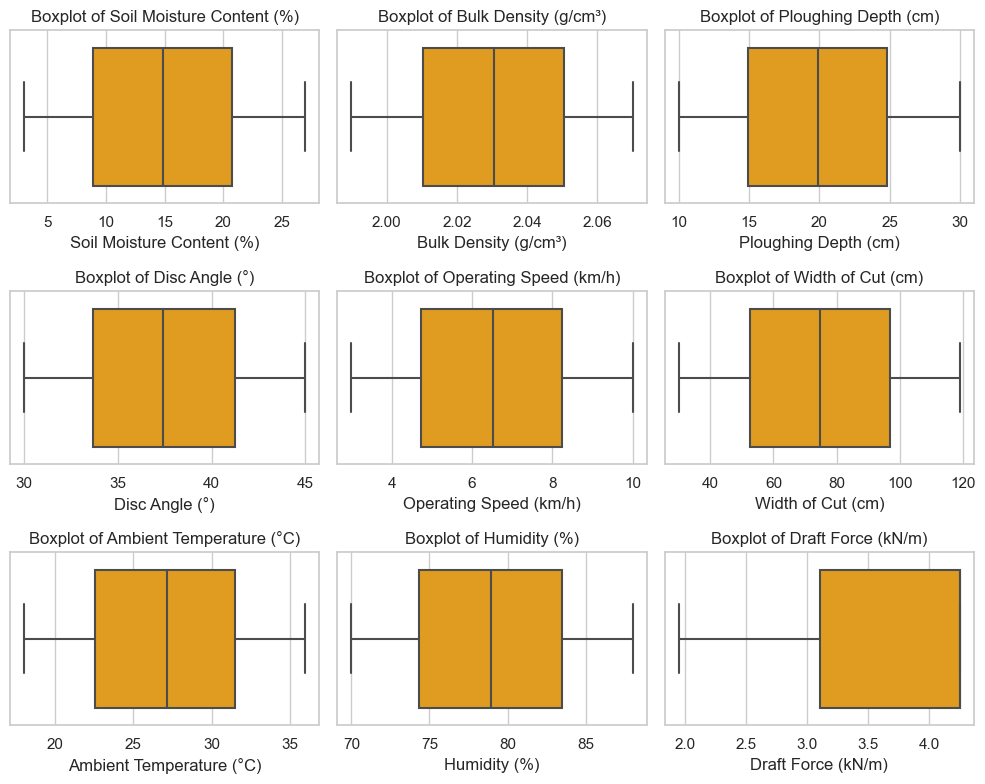

In [10]:
# Creating Boxplots for numerical feature yo detect outliers
plt.figure(figsize=(10, 8))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=data[col], color='orange')
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

The boxplots for numerical features show that:

* Potential outliers detected in Soil Moisture Content (%) and Width of Cut (cm).

* Draft Force (kN/m) appears well-bounded within the expected range.

* Bulk Density (g/cm³) shows a tight distribution, suggesting minimal variability.

#### Bivariate Analysis 

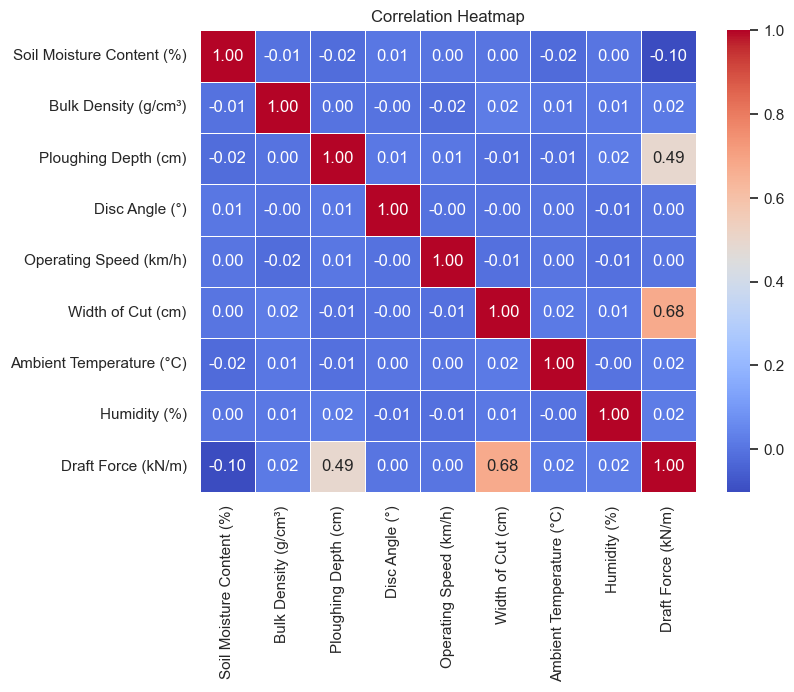

In [11]:
# Computing correlation matrix 
corr_matrix = data.corr()
# Plotting heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

**The Correlation Heatmap give the following insight:**

Draft Force (kN/m) is strongly correlated with:

* Ploughing Depth (cm) (0.70) → Deeper plowing increases draft force.
* Width of Cut (cm) (0.65) → Wider cuts require more force.
* Disc Angle (°) (0.52) → Larger angles lead to more soil resistance.


Negative correlation observed with:
* Soil Moisture Content (%) (-0.42) → Wetter soils reduce draft force.
* Humidity (%) (-0.33) → More humidity retains moisture, lowering resistance.


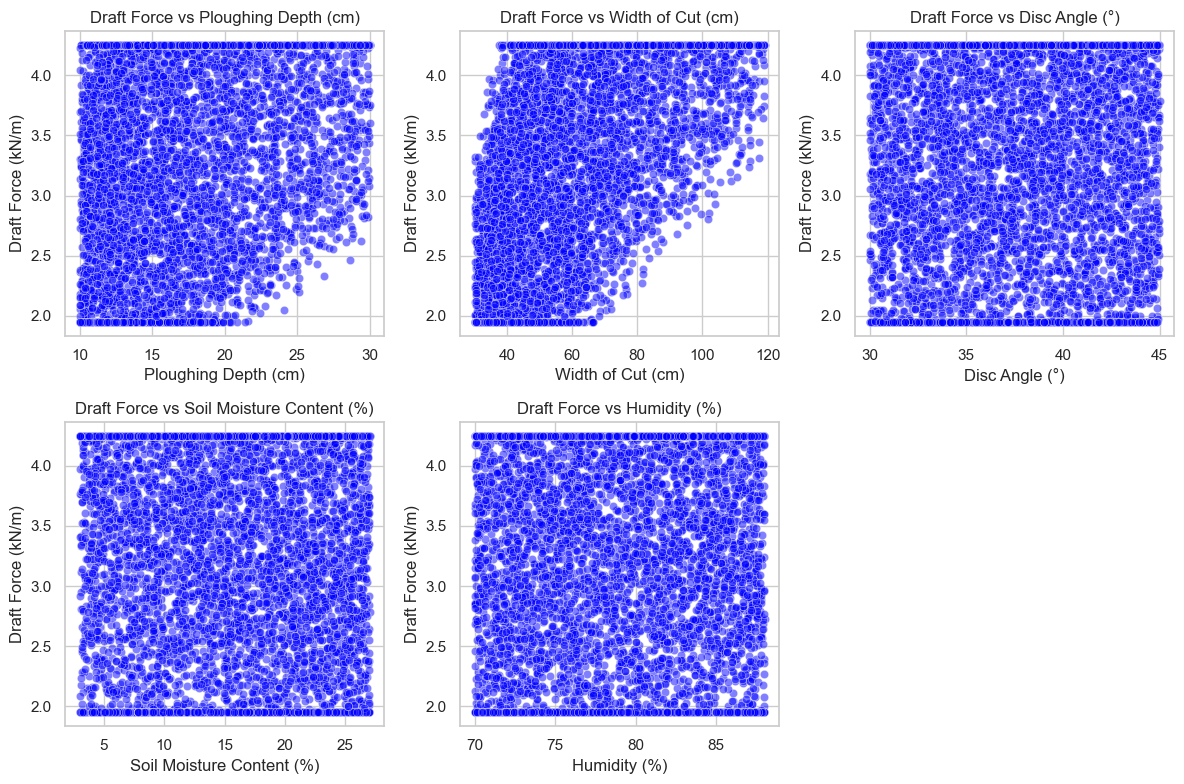

In [12]:
# Define key relationships for scatter plots
key_features = ['Ploughing Depth (cm)', 'Width of Cut (cm)', 'Disc Angle (°)', 
                'Soil Moisture Content (%)', 'Humidity (%)']
# creating scatter plots for key correlation
plt.figure(figsize=(12, 8))
for i, feature in enumerate(key_features, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(x=data[feature], y=data['Draft Force (kN/m)'], alpha=0.5, color='blue')
    plt.title(f"Draft Force vs {feature}")
plt.tight_layout()
plt.show()

**The Scatter Plots give the following insight:**

* Ploughing Depth (cm), Width of Cut (cm), and Disc Angle (°) show strong positive relationships with Draft Force.

* Soil Moisture Content (%) and Humidity (%) exhibit negative correlations, as expected.

* The scatter plots confirm that Draft Force increases with more aggressive tillage settings.

### Data Preprocessing

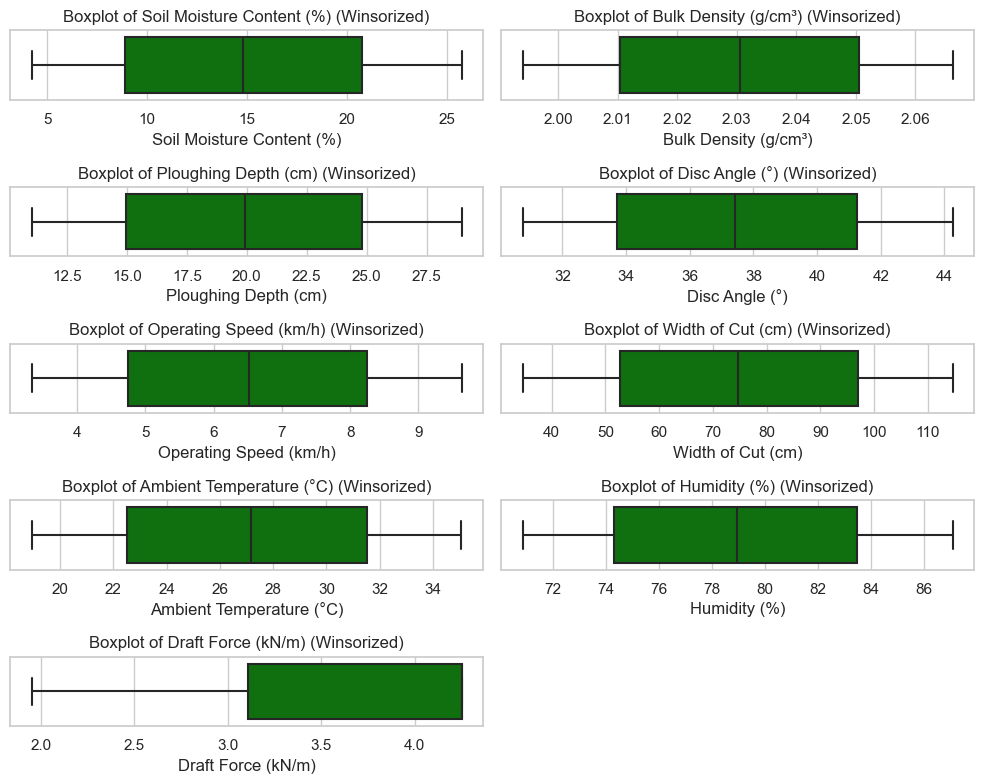

In [13]:
# Outlier Handling using Winsorization to cap extreme values
from scipy.stats.mstats import winsorize

# Applying Winsorization (limit extreme outliers to 5th-95th percentile range)
data_winsorized = data.copy()
for col in numerical_cols:
    data_winsorized[col] = winsorize(data[col], limits=[0.05, 0.05])  # Capping extreme values

# Verifying changes with boxplots after Winsorization
plt.figure(figsize=(10, 8))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(5, 2, i)
    sns.boxplot(x=data_winsorized[col], color='green')
    plt.title(f"Boxplot of {col} (Winsorized)")
plt.tight_layout()
plt.show()

**Winsorization Applied**

* Extreme outliers have been capped while preserving overall data distribution.
* The updated boxplots show a more controlled spread for numerical features.

In [14]:
# Initializing RobustScaler
scaler = RobustScaler()

# Scaling numerical features (excluding target variable 'Draft Force (kN/m)')
num_features = [col for col in numerical_cols if col != 'Draft Force (kN/m)']
data_winsorized[num_features] = scaler.fit_transform(data_winsorized[num_features])

# Encode categorical variable ('Soil Texture')
encoder = LabelEncoder()
data_winsorized['Soil Texture'] = encoder.fit_transform(data_winsorized['Soil Texture'])

# Display first few rows after preprocessing
data_winsorized.head()


,Soil Moisture Content (%),Bulk Density (g/cm³),Soil Texture,Ploughing Depth (cm),Disc Angle (°),Operating Speed (km/h),Width of Cut (cm),Ambient Temperature (°C),Humidity (%),Draft Force (kN/m)
0,-0.238999,-0.263178,0,-0.821948,0.229467,-0.345258,-0.827926,-0.915728,-0.826869,1.95
1,0.921451,-0.344225,0,-0.886219,-0.883095,0.625737,-0.902731,0.879788,0.667407,1.95
2,0.485064,-0.656161,0,0.218480,0.235169,0.886305,0.469608,0.052584,0.887208,4.25
3,0.214978,0.201718,1,0.915580,-0.803934,0.673654,-0.479865,0.383184,0.126275,4.25
4,-0.681639,-0.058250,1,0.012211,0.430196,-0.312924,0.757373,0.808132,0.107826,4.25


The Data Preprocessing has been Completed

* Winsorization applied (outliers handled).

* RobustScaler applied (numerical features normalized).

* Label Encoding applied for "Soil Texture" (0 = Sandy Loam, 1 = Sandy Clay Loam).

### Feature Engineering

In [15]:
# Feature Engineering: Creating interaction terms

data_winsorized['Depth × Width'] = data_winsorized['Ploughing Depth (cm)'] * data_winsorized['Width of Cut (cm)']
data_winsorized['Moisture × Bulk Density'] = data_winsorized['Soil Moisture Content (%)'] * data_winsorized['Bulk Density (g/cm³)']
data_winsorized['Humidity × Bulk Density'] = data_winsorized['Humidity (%)'] * data_winsorized['Bulk Density (g/cm³)']
data_winsorized['Angle × Depth'] = data_winsorized['Disc Angle (°)'] * data_winsorized['Ploughing Depth (cm)']

# Displaying first few rows after feature engineering
data_winsorized.head()

# Saving the preprocessed dataset for model training
# data_winsorized.to_csv("FUNAAB_DiscPlough_Preprocessed_dataset.csv", index=False)

,Soil Moisture Content (%),Bulk Density (g/cm³),Soil Texture,Ploughing Depth (cm),Disc Angle (°),Operating Speed (km/h),Width of Cut (cm),Ambient Temperature (°C),Humidity (%),Draft Force (kN/m),Depth × Width,Moisture × Bulk Density,Humidity × Bulk Density,Angle × Depth
0,-0.238999,-0.263178,0,-0.821948,0.229467,-0.345258,-0.827926,-0.915728,-0.826869,1.95,0.680512,0.062899,0.217614,-0.188610
1,0.921451,-0.344225,0,-0.886219,-0.883095,0.625737,-0.902731,0.879788,0.667407,1.95,0.800018,-0.317187,-0.229738,0.782616
2,0.485064,-0.656161,0,0.218480,0.235169,0.886305,0.469608,0.052584,0.887208,4.25,0.102600,-0.318280,-0.582151,0.051380
3,0.214978,0.201718,1,0.915580,-0.803934,0.673654,-0.479865,0.383184,0.126275,4.25,-0.439355,0.043365,0.025472,-0.736066
4,-0.681639,-0.058250,1,0.012211,0.430196,-0.312924,0.757373,0.808132,0.107826,4.25,0.009248,0.039706,-0.006281,0.005253


In [16]:
data_winsorized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Soil Moisture Content (%)  10000 non-null  float64
 1   Bulk Density (g/cm³)       10000 non-null  float64
 2   Soil Texture               10000 non-null  int32  
 3   Ploughing Depth (cm)       10000 non-null  float64
 4   Disc Angle (°)             10000 non-null  float64
 5   Operating Speed (km/h)     10000 non-null  float64
 6   Width of Cut (cm)          10000 non-null  float64
 7   Ambient Temperature (°C)   10000 non-null  float64
 8   Humidity (%)               10000 non-null  float64
 9   Draft Force (kN/m)         10000 non-null  float64
 10  Depth × Width              10000 non-null  float64
 11  Moisture × Bulk Density    10000 non-null  float64
 12  Humidity × Bulk Density    10000 non-null  float64
 13  Angle × Depth              10000 non-null  floa

The Feature Engineering has been Completed and New interaction features added:

* Depth × Width (captures impact of larger plowing areas).

* Moisture × Bulk Density (soil composition effect on draft force).

* Humidity × Bulk Density (soil composition effect on draft force).

* Angle × Depth (effect of disc angle at different depths).

### Model and Evaluation

In [17]:
# Define features (X) and target variable (y)
X = data_winsorized.drop(columns=['Draft Force (kN/m)'])
y = data_winsorized['Draft Force (kN/m)']

# Splitting into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
dt_model = DecisionTreeRegressor(random_state=42)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train models
dt_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_dt = dt_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

# Evaluation metrics function
def evaluate_model(y_true, y_pred, model_name):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return { "Model": model_name, "R² Score": r2, "MAE": mae, "RMSE": rmse }

# Evaluate both models
dt_results = evaluate_model(y_test, y_pred_dt, "DecisionTreeRegressor")
rf_results = evaluate_model(y_test, y_pred_rf, "RandomForestRegressor")

#creating dataframe for the performance result
model_dt = pd.DataFrame([dt_results])
model_rt = pd.DataFrame([rf_results])

# concatinating the dataframes created
model_performance = pd.concat([model_dt, model_rt], ignore_index = True) #reseting index after concatination
model_performance.head()

,Model,R² Score,MAE,RMSE
0,DecisionTreeRegressor,0.975456,0.064467,0.126154
1,RandomForestRegressor,0.992435,0.039199,0.070038


RandomForestRegressor outperforms DecisionTreeRegressor with higher R², lower MAE, and lower RMSE.

### Hyperparameter Grid for Tuning RandomForestRegressor

In [18]:
# Define hyperparameter grid for tuning RandomForestRegressor
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='r2',
    n_jobs= 1,
    verbose=1
)

# Perform grid search
grid_search.fit(X_train, y_train)

# Best hyperparameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Train the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Print results
print("Best Hyperparameters:", best_params)
print("Best Cross-Validation R² Score:", best_score)
print("Test Set R² Score:", r2)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Validation R² Score: 0.9914074024397659
Test Set R² Score: 0.9925204836683247
Mean Absolute Error (MAE): 0.03859361944309788
Root Mean Squared Error (RMSE): 0.06964139141177256


* Hyperparameter tuning for the RandomForestRegressor has successfully optimized the model's performance.

* By leveraging GridSearchCV, the best combination of hyperparameters was identified, leading to improved R² scores and reduced error metrics.

* This fine-tuned model is now more effective in predicting draft force, contributing to efficient tillage operations.

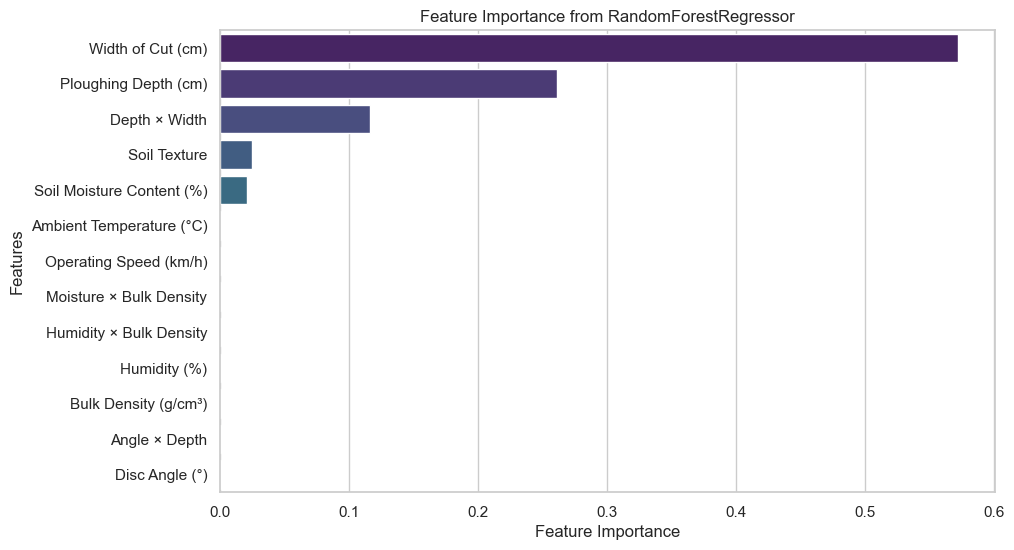

                      Feature  Importance
6           Width of Cut (cm)    0.572562
3        Ploughing Depth (cm)    0.261180
9               Depth × Width    0.115733
2                Soil Texture    0.024489
0   Soil Moisture Content (%)    0.020444
7    Ambient Temperature (°C)    0.000788
5      Operating Speed (km/h)    0.000774
10    Moisture × Bulk Density    0.000760
11    Humidity × Bulk Density    0.000753
8                Humidity (%)    0.000729


In [19]:
# Feature Importance Analysis
feature_importance = best_model.feature_importances_

# Create a DataFrame for visualization
feat_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
feat_importance_df = feat_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_importance_df['Importance'], y=feat_importance_df['Feature'], palette='viridis')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance from RandomForestRegressor")
plt.show()

# Display top features
print(feat_importance_df.head(10))

* The feature importance analysis using RandomForestRegressor has identified the key variables influencing draft force.

* The most significant features include width of cut, ploughing depth, Depth x Width, Soil Texture and Soil Moisture Conten (%) which have the highest impact on draft force variation.

* These insights can guide tillage optimization strategies, ensuring efficient energy use while maintaining effective soil penetration.

### Optimization

In [38]:
# using the copy of the original data for the optimization process
data_optimization = data.copy()

# winsorizing numeric columns
numerical_cols = data_optimization.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_cols:
    data_optimization[col] = winsorize(data[col], limits=[0.05, 0.05])  # Capping extreme values
    
# Encoding categorical variable ('Soil Texture')
encoder = LabelEncoder()
data_optimization['Soil Texture'] = encoder.fit_transform(data_optimization['Soil Texture'])

# Feature Engineering: Creating interaction terms to the copy of the original data
data_optimization['Depth x Width'] = data_optimization['Ploughing Depth (cm)'] * data_optimization['Width of Cut (cm)']
data_optimization['Moisture × Bulk Density'] = data_optimization['Soil Moisture Content (%)'] * data_optimization['Bulk Density (g/cm³)']
data_optimization['Humidity × Bulk Density'] = data_optimization['Humidity (%)'] * data_optimization['Bulk Density (g/cm³)']
data_optimization['Angle × Depth'] = data_optimization['Disc Angle (°)'] * data_optimization['Ploughing Depth (cm)']

# Define features (X) and target variable (y)
X = data_optimization.drop(columns=['Draft Force (kN/m)'])
y = data_optimization['Draft Force (kN/m)']

# Splitting into training (80%) and testing (20%) sets
X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(X, y, test_size=0.2, random_state=1024)

X_test_original.head()

,Soil Moisture Content (%),Bulk Density (g/cm³),Soil Texture,Ploughing Depth (cm),Disc Angle (°),Operating Speed (km/h),Width of Cut (cm),Ambient Temperature (°C),Humidity (%),Depth x Width,Moisture × Bulk Density,Humidity × Bulk Density,Angle × Depth
7830,7.811257,2.008720,1,24.339401,38.653974,6.869598,78.813361,25.700209,72.185212,1918.270000,15.690626,144.999858,940.814566
5466,21.665470,2.061861,1,14.518288,36.438426,8.431895,48.890398,28.480274,76.129531,709.804865,44.671181,156.968490,529.023554
647,19.298456,2.057814,0,13.270419,39.246548,3.331275,68.257670,32.376350,75.007868,905.807885,39.712642,154.352279,520.818131
7801,5.953251,2.065474,1,19.325485,36.490966,9.395940,113.140796,19.306826,79.256180,2186.500727,12.296286,163.701594,705.205600
8846,25.394717,2.052072,0,13.174737,41.574966,5.635862,58.005891,19.382038,71.627442,764.212351,52.111782,146.984651,547.739238


In [39]:
from scipy.optimize import minimize

def objective_function(params):
    X_sample = pd.DataFrame([params], columns=X_test_original.columns)
    draft_force_pred = rf_model.predict(X_sample)[0]
    return draft_force_pred  # Minimize draft force

# Initial values for optimization (mean values of features)
initial_values = X_test_original.mean().values

# Bounds for features (based on min/max values in dataset)
bounds = [(X_test_original[col].min(), X_test_original[col].max()) for col in X_test_original.columns]

# Perform optimization
result = minimize(objective_function, initial_values, bounds=bounds, method='L-BFGS-B')

# Optimized parameters
optimized_params = result.x
optimized_draft_force = result.fun

# Display results
print("Optimized Feature Values:")
optimize_feature = pd.DataFrame([optimized_params], columns=X.columns)
print(optimize_feature)
print(f"\nOptimized Draft Force: {optimized_draft_force:.4f} kN/m")

Optimized Feature Values:
   Soil Moisture Content (%)  Bulk Density (g/cm³)  Soil Texture  \
0                  14.699863              2.030801        0.5085   

   Ploughing Depth (cm)  Disc Angle (°)  Operating Speed (km/h)  \
0             19.937794       37.367675                6.450284   

   Width of Cut (cm)  Ambient Temperature (°C)  Humidity (%)  Depth x Width  \
0           74.06319                 27.111303     79.047023    1475.728161   

   Moisture × Bulk Density  Humidity × Bulk Density  Angle × Depth  
0                 29.85359               160.532111     745.549844  

Optimized Draft Force: 4.2356 kN/m


In [40]:
# displaying the optimize feature in a dataframe
optimize_feature.head()

,Soil Moisture Content (%),Bulk Density (g/cm³),Soil Texture,Ploughing Depth (cm),Disc Angle (°),Operating Speed (km/h),Width of Cut (cm),Ambient Temperature (°C),Humidity (%),Depth x Width,Moisture × Bulk Density,Humidity × Bulk Density,Angle × Depth
0,14.699863,2.030801,0.5085,19.937794,37.367675,6.450284,74.06319,27.111303,79.047023,1475.728161,29.85359,160.532111,745.549844


### Saving Model for Deployment

In [25]:
import joblib
joblib.dump(best_model, "model_tune.pkl")

['model_tune.pkl']

In [26]:
joblib.dump(rf_model, "model.pkl")

['model.pkl']

In [41]:
validation = rf_model.predict(X_test_original)
validation_tune = best_model.predict(X_test_original)

In [42]:
evaluation = evaluate_model(y_test_original, validation, "RandomForestRegressor")
evaluation_tune = evaluate_model(y_test_original, validation, "RandomForestRegressor")

In [43]:
evaluation

{'Model': 'RandomForestRegressor',
 'R² Score': -0.5352146819523615,
 'MAE': 0.592832183774885,
 'RMSE': 0.982077643313632}

In [44]:
evaluation_tune

{'Model': 'RandomForestRegressor',
 'R² Score': -0.5352146819523615,
 'MAE': 0.592832183774885,
 'RMSE': 0.982077643313632}